## Installing libraries that are not in collab

In [1]:
# Install Transformers
!pip install transformers
# To get model summary
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.3 MB/s 
     |████████████████████████████████| 120 kB 67.6 MB/s 
     |████████████████████████████████| 6.6 MB 30.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

In [3]:
drive.mount("/content/gdrive")
!ls

Mounted at /content/gdrive
gdrive	sample_data  test_data.xlsx  train_data.xlsx


## Import Libraries
Importing the libraries that are required to perform operations on the dataset.

In [4]:
import json
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report,f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, DistilBertModel, RobertaTokenizer, RobertaModel, AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## Data preprocessing
Doing required processing of data.

In [5]:
df_train = pd.read_excel("train_data.xlsx")
df_test = pd.read_excel("test_data.xlsx")

In [6]:
df_train.head()

,text,intent
0,Hi,greeting
1,How are you,greeting
2,Good morning,greeting
3,Good afternoon,greeting
4,Good evening,greeting


In [7]:
df_test.head()

,text,intent
0,hello there,greeting
1,How is everything,greeting
2,Howâ€™s everything going,greeting
3,Good to see you,greeting
4,How you doing,greeting


In [8]:
len_labels = len(df_train.intent.unique())

In [9]:
df_train["intent"].value_counts()

course                    41
fees                      41
hostel                    41
scholarship               31
event                     28
canteen                   28
creator                   28
name                      28
hours                     28
number                    28
goodbye                   28
infrastructure            28
document                  28
syllabus                  28
library                   28
greeting                  27
location                  27
transport                 25
sports                    23
faculty                   23
college intake            23
fest                      21
medical                   20
facilities                20
salutation                19
ragging                   19
admission                 19
uniform                   18
random                    16
task                      15
placement                 13
menu                      13
notice                    13
hod                       12
principal     

In [10]:
df_test["intent"].value_counts()

greeting                  5
admission                 5
uniform                   5
random                    5
swear                     5
salutation                5
task                      5
ragging                   5
hod                       5
transport                 5
scholarship               5
faculty                   5
student portal            5
faculty portal            5
sports                    5
fest                      5
university affiliation    5
medical                   5
college type              5
college intake            5
facilities                5
infrastructure            5
principal                 5
name                      5
hours                     5
number                    5
course                    5
fees                      5
location                  5
hostel                    5
notice                    5
event                     5
document                  5
syllabus                  5
library                   5
canteen             

In [11]:
# Converting the labels into encodings
le = LabelEncoder()
df_test['intent'] = le.fit_transform(df_test['intent'])
df_train['intent'] = le.fit_transform(df_train['intent'])

In [12]:
# check class distribution
df_train['intent'].value_counts(normalize = True)

4     0.046380
12    0.046380
17    0.046380
33    0.035068
8     0.031674
1     0.031674
5     0.031674
24    0.031674
18    0.031674
26    0.031674
14    0.031674
19    0.031674
7     0.031674
37    0.031674
20    0.031674
15    0.030543
21    0.030543
39    0.028281
34    0.026018
10    0.026018
2     0.026018
13    0.023756
22    0.022624
9     0.022624
32    0.021493
30    0.021493
0     0.021493
40    0.020362
31    0.018100
38    0.016968
28    0.014706
23    0.014706
25    0.014706
16    0.013575
29    0.011312
36    0.010181
35    0.010181
41    0.009050
11    0.007919
6     0.007919
3     0.005656
27    0.001131
Name: intent, dtype: float64

In [13]:
# check class distribution
df_test['intent'].value_counts(normalize = True)

15    0.024752
0     0.024752
40    0.024752
31    0.024752
36    0.024752
32    0.024752
38    0.024752
30    0.024752
16    0.024752
39    0.024752
33    0.024752
10    0.024752
35    0.024752
11    0.024752
34    0.024752
13    0.024752
41    0.024752
22    0.024752
3     0.024752
2     0.024752
9     0.024752
19    0.024752
29    0.024752
24    0.024752
18    0.024752
26    0.024752
4     0.024752
12    0.024752
21    0.024752
17    0.024752
25    0.024752
8     0.024752
7     0.024752
37    0.024752
20    0.024752
1     0.024752
23    0.024752
28    0.024752
6     0.024752
5     0.014851
14    0.014851
27    0.004950
Name: intent, dtype: float64

In [14]:
# In this example we have used all the utterances for training purpose
train_text, train_labels = df_train["text"], df_train["intent"]
test_text, test_labels = df_test["text"], df_test["intent"]


### Load Tokenizer

In [15]:
def load_tokenizer(model="bert"):
  tokenizer = None
  if model == "bert":
    # Load the BERT tokenizer
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
  if model == "roberta":
    # Load the Roberta tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
  if model == "distilbert":
    # Load the DistilBert tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

  return tokenizer

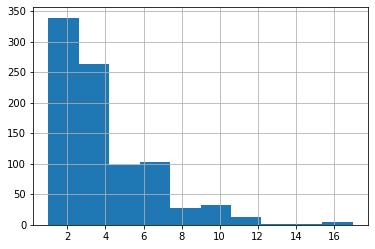

In [17]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 10)

# Based on the histogram we are selecting the max len as 9
max_seq_len = 16

In [18]:
def get_tokenized_data(model="bert"):
  tokenizer = load_tokenizer(model=model)
  # tokenize and encode sequences in the training set
  tokens_train = tokenizer(
      train_text.tolist(),
      max_length = max_seq_len,
      padding="max_length",
      truncation=True,
      return_token_type_ids=False
                    )
  # tokenize and encode sequences in the testing set
  tokens_test = tokenizer(
      test_text.tolist(),
      max_length = max_seq_len,
      padding="max_length",
      truncation=True,
      return_token_type_ids=False
  )
  return tokens_train, tokens_test

In [19]:
tokens_train, tokens_test = get_tokenized_data("roberta")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [20]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [21]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## Setting Up models parameters

In [22]:
# Define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set and test set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Building our Lucy Model
To build lucy we are going to use pretrained Model and our own model.

### 1) Lucy layer

In [23]:
class Lucy(nn.Module):
  def __init__(self, pretrained_model):      
       super(Lucy, self).__init__()       
       self.pretrained_model = pretrained_model 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()     

       # dense layer       
       self.fc1 = nn.Linear(768,512)       
       self.fc2 = nn.Linear(512,256)       
       self.fc3 = nn.Linear(256,len_labels)    

       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)      
      
  #define the forward pass
  def forward(self, sent_id, mask):      
      #pass the inputs to the model  
      cls_hs = self.pretrained_model(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)      

      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)     
      return x

### 2) Pretrained layer + Lucy layer

In [24]:
def lucy_model(device,model="bert"):
  pretrained_model = None
  if model == "bert":
    # Import BERT-base pretrained model
    pretrained_model = AutoModel.from_pretrained("bert-base-uncased")

  if model == "roberta":
    # Import Roberta pretrained model
    pretrained_model = RobertaModel.from_pretrained("roberta-base")

  if model == "distilbert":
    # Import the DistilBert pretrained model
    pretrained_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

  # freeze all the parameters. This will prevent updating of model weights during fine-tuning.
  for param in pretrained_model.parameters():
        param.requires_grad = False

  lucy = Lucy(pretrained_model)

  # push the model to GPU or CPU
  lucy = lucy.to(device)

  return lucy

#### i) BERT

In [25]:
bert_model = lucy_model(device)
summary(bert_model)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                  Param #
Lucy                                                    --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             (85,054,464)
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linea

#### ii) Roberta

In [26]:
roberta_model = lucy_model(device, model="roberta")
summary(roberta_model)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                       Param #
Lucy                                                         --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (38,603,520)
│    │    └─Embedding: 3-2                                   (394,752)
│    │    └─Embedding: 3-3                                   (768)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─RobertaPooler: 2-3                                    --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                           

#### iii) DistilBert 

In [27]:
distilbert_model = lucy_model(device, model="distilbert")
summary(distilbert_model)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                  Param #
Lucy                                                    --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           10,794
├─LogSoftmax: 1-7                                       --
Total

In [28]:
# define the optimizer for BERT, Roberta, DistilBERT
bert_optimizer = torch.optim.AdamW(bert_model.parameters(), lr = 1e-3)
roberta_optimizer = torch.optim.AdamW(roberta_model.parameters(), lr = 1e-3)
distilbert_optimizer = torch.optim.AdamW(distilbert_model.parameters(), lr = 1e-3)

In [29]:
#compute the class weights
class_wts = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
print(class_wts)

[ 1.10776942  0.75170068  0.91511387  4.20952381  0.51335656  0.75170068
  3.00680272  0.75170068  0.75170068  1.05238095  0.91511387  3.00680272
  0.51335656  1.00226757  0.75170068  0.77954145  1.75396825  0.51335656
  0.75170068  0.75170068  0.75170068  0.77954145  1.05238095  1.61904762
  0.75170068  1.61904762  0.75170068 21.04761905  1.61904762  2.1047619
  1.10776942  1.31547619  1.10776942  0.67895545  0.91511387  2.33862434
  2.33862434  0.75170068  1.4031746   0.84190476  1.16931217  2.63095238]


In [30]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

In [31]:
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [32]:
# empty lists to store training  loss of each epoch
train_losses=[]

# empty lists to store training  accuracy of each epoch
train_accuracies=[]

# number of training epochs
epochs = 500

In [33]:
# function to train the model
def train(dataloader, model, optimizer):
  
  model.train()
  total_loss = 0
  total_correct = 0
  
  # empty list to save model predictions
  total_preds=[]

   # iterate over batches
  for step,batch in enumerate(dataloader):
    # progress update after every 15 batches.
    if step % 50 == 0 and not step == 0:
      print('Batch {:>5,}  of  {:>5,}.'.format(step,    len(dataloader)))

    # push the batch to gpu or cpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # get model accuracy
    p = preds.detach().cpu().numpy()
    p = torch.from_numpy(np.argmax(p, axis = 1))
    
    total_correct += (p == labels.detach().cpu()).float().sum()


    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # clear calculated gradients
    optimizer.zero_grad()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)
  
  # compute the training accuracy of the epoch
  avg_accuracy = total_correct / len(train_data)
 
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions
  return avg_loss, avg_accuracy, total_preds
  
 

In [34]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_accuracy ,_ = train(train_dataloader, roberta_model, roberta_optimizer)
    
    # append training loss
    train_losses.append(train_loss)

    # appedn training accuracy
    train_accuracies.append(train_accuracy)

    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'\nTraining Accuracy: {train_accuracy * 100:.3f} %')


 Epoch 1 / 500
Batch    50  of     56.

Training Loss: 3.757

Training Accuracy: 1.471 %

 Epoch 2 / 500
Batch    50  of     56.

Training Loss: 3.741

Training Accuracy: 3.620 %

 Epoch 3 / 500
Batch    50  of     56.

Training Loss: 3.742

Training Accuracy: 2.489 %

 Epoch 4 / 500
Batch    50  of     56.

Training Loss: 3.741

Training Accuracy: 2.828 %

 Epoch 5 / 500
Batch    50  of     56.

Training Loss: 3.753

Training Accuracy: 3.054 %

 Epoch 6 / 500
Batch    50  of     56.

Training Loss: 3.720

Training Accuracy: 3.394 %

 Epoch 7 / 500
Batch    50  of     56.

Training Loss: 3.707

Training Accuracy: 3.959 %

 Epoch 8 / 500
Batch    50  of     56.

Training Loss: 3.683

Training Accuracy: 4.072 %

 Epoch 9 / 500
Batch    50  of     56.

Training Loss: 3.651

Training Accuracy: 4.299 %

 Epoch 10 / 500
Batch    50  of     56.

Training Loss: 3.600

Training Accuracy: 5.882 %

 Epoch 11 / 500
Batch    50  of     56.

Training Loss: 3.569

Training Accuracy: 5.204 %

 Epoch 

## Analysis of Training

In [35]:
train_losses = np.array(train_losses)
train_accuracies = np.array(train_accuracies)

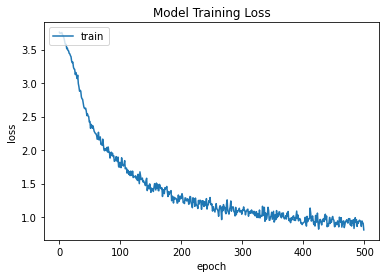

In [36]:
plt.plot(train_losses)
plt.title("Model Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.savefig("roberta_model_loss.png")
plt.show()

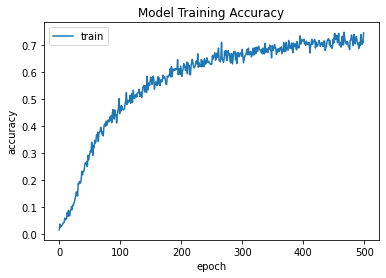

In [37]:
plt.plot(train_accuracies)
plt.title("Model Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.savefig("roberta_model_accuracy.png")
plt.show()

## Saving the Lucy model

In [39]:
model_save_name = "lucy_roberta.pth"
PATH = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(roberta_model.state_dict(), PATH)

In [40]:
roberta_model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

## Testing the Lucy

In [41]:
# empty lists to store testing  loss of each epoch
test_losses=[]

# empty lists to store tesing  accuracy of each epoch
test_accuracies=[]

In [42]:
@torch.no_grad()
def test(dataloader, model):
  total_loss = 0
  total_correct = 0
  
  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print("Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader))")

    # push the batch to gpu or cpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    
    # compute the accuracy
    p = preds.detach().cpu().numpy()
    p = torch.from_numpy(np.argmax(p, axis = 1))
    
    total_correct += (p == labels.detach().cpu()).float().sum()

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)

  # compute the training accuracy of the epoch
  avg_accuracy = total_correct / len(train_data)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions

  return avg_loss,avg_accuracy, total_preds
  
 

In [43]:
test_loss, test_accuracy , test_y_preds = test(test_dataloader, roberta_model)

print(f'\nTesting Loss: {test_loss:.3f}')
print(f'\nTesting Accuracy: {test_accuracy * 100:.3f} %')


Testing Loss: 2.384

Testing Accuracy: 10.973 %


In [44]:
test_y_preds = np.argmax(torch.tensor(test_y_preds), axis=-1)

In [45]:
classes = le.classes_.tolist()

In [46]:
test_y_true = []
for batch in test_dataloader:
   _, _, labels = batch
   a = torch.Tensor.tolist(labels)
   for i in a:
     test_y_true.append(i)
  

In [47]:
test_y_true = le.inverse_transform(test_y_true)

In [48]:
test_y_preds = le.inverse_transform(test_y_preds)

In [49]:
# Classification report
classification_report(test_y_true, test_y_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                        precision    recall  f1-score   support\n\n             admission       0.50      0.60      0.55         5\n               canteen       0.60      0.60      0.60         5\n        college intake       0.67      0.40      0.50         5\n          college type       0.67      0.40      0.50         5\n                course       0.12      0.40      0.19         5\n               creator       0.50      1.00      0.67         3\n                csehod       0.40      0.40      0.40         5\n              document       0.25      0.20      0.22         5\n                 event       0.29      0.40      0.33         5\n            facilities       0.00      0.00      0.00         5\n               faculty       0.50      0.40      0.44         5\n        faculty portal       0.60      0.60      0.60         5\n                  fees       0.75      0.60      0.67         5\n                  fest       0.50      0.40      0.44         5\n               goodbye

In [50]:
# Build confusion matrix
cf_matrix = confusion_matrix(test_y_true, test_y_preds)

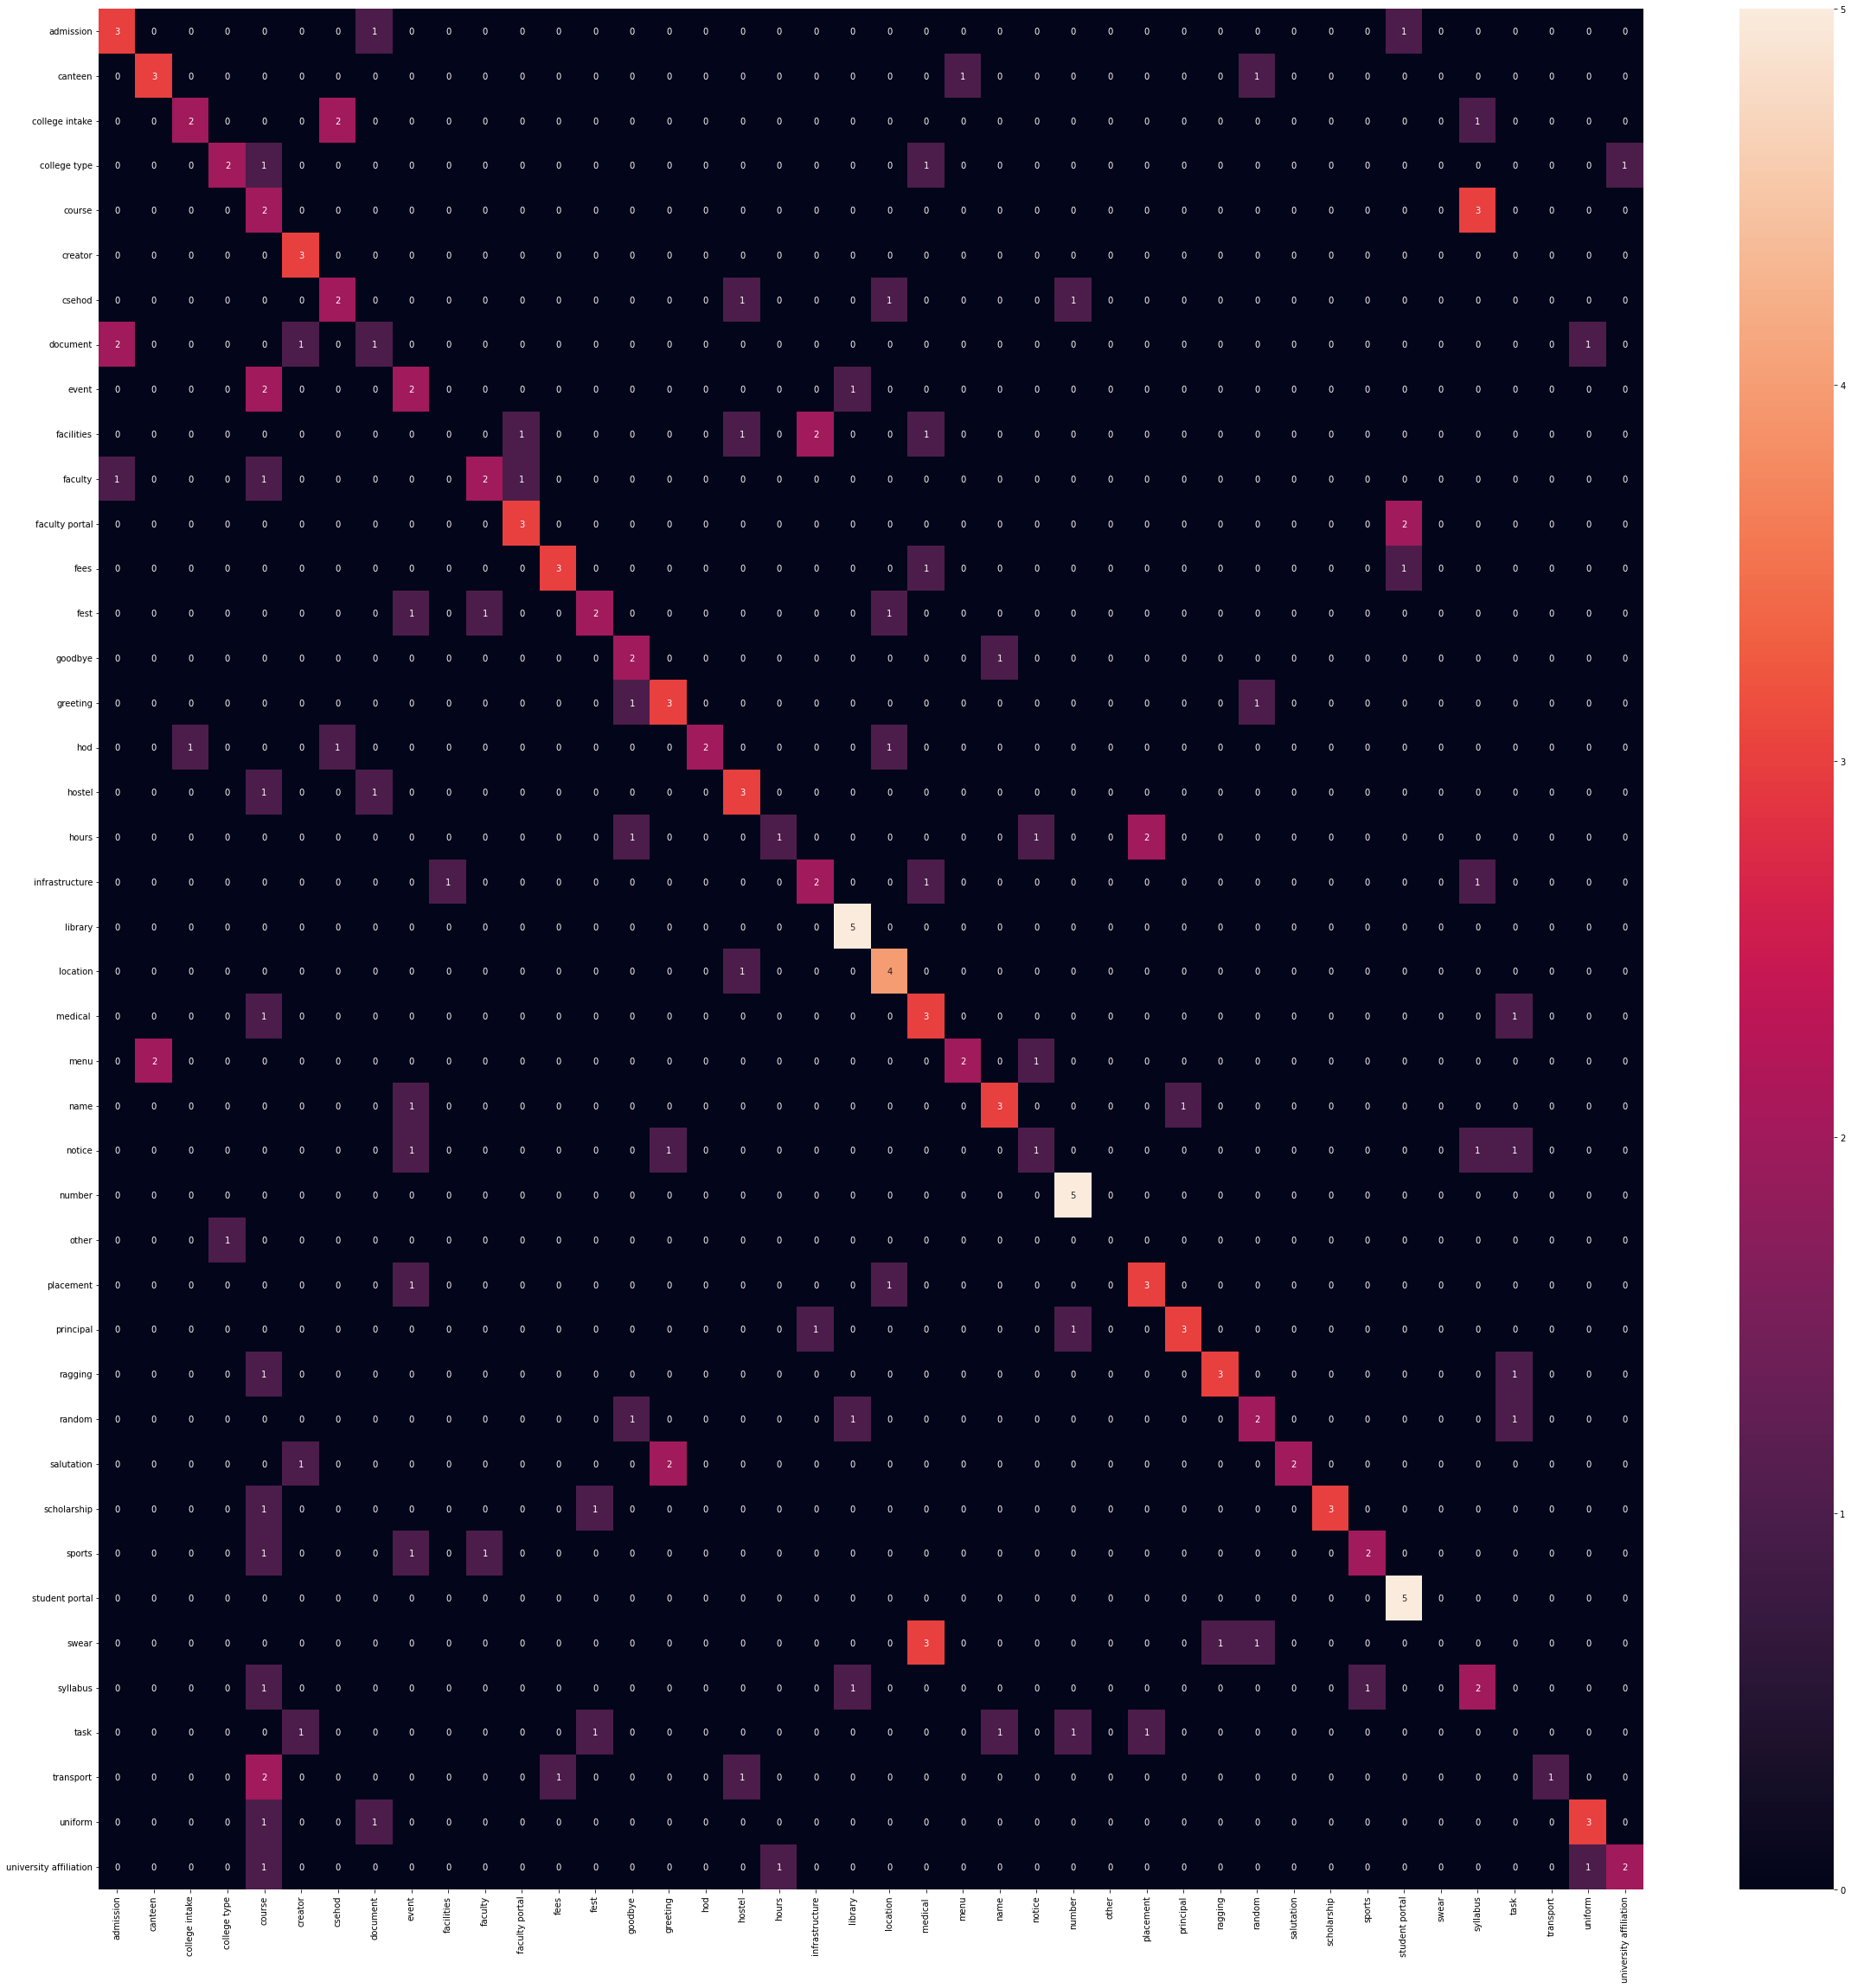

In [51]:
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (40,40))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix_roberta.png')

In [52]:
import json

classes = le.classes_.tolist()
filename = 'labels.json'
with open(filename, 'w') as file_object:  
  json.dump(classes, file_object)